In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.optimize import brentq
from scipy.stats import t, norm
import matplotlib.pyplot as plt

## Question 1

In [2]:
df1 = pd. read_csv("DailyPrices.csv", parse_dates=["Date"], index_col="Date")

#### 1A

In [3]:
arith_returns = df1[['SPY', 'AAPL', 'EQIX']].pct_change().dropna()
arith_demeaned = arith_returns - arith_returns.mean()

print ("last 5 rows of demeaned arithmetic returns")
print(arith_demeaned. tail(5))
print("\nstandard deviations of demeaned arithmetic returns")
print(arith_demeaned. std ())

last 5 rows of demeaned arithmetic returns
                 SPY      AAPL      EQIX
Date                                    
2024-12-27 -0.011492 -0.014678 -0.006966
2024-12-30 -0.012377 -0.014699 -0.008064
2024-12-31 -0.004603 -0.008493  0.006512
2025-01-02 -0.003422 -0.027671  0.000497
2025-01-03  0.011538 -0.003445  0.015745

standard deviations of demeaned arithmetic returns
SPY     0.008077
AAPL    0.013483
EQIX    0.015361
dtype: float64


#### 1B

In [4]:
log_returns = np. log(df1[['SPY', 'AAPL', 'EQIX']]) - np. log(df1[['SPY', 'AAPL', 'EQIX']].shift (1))
log_returns = log_returns.dropna()
log_demeaned = log_returns - log_returns.mean()
print("last 5 rows of demeaned log returns")
print(log_demeaned. tail ())
print("\nstandard deviations of demeaned log returns")
print (log_demeaned. std())

last 5 rows of demeaned log returns
                 SPY      AAPL      EQIX
Date                                    
2024-12-27 -0.011515 -0.014675 -0.006867
2024-12-30 -0.012410 -0.014696 -0.007972
2024-12-31 -0.004577 -0.008427  0.006602
2025-01-02 -0.003392 -0.027930  0.000613
2025-01-03  0.011494 -0.003356  0.015725

standard deviations of demeaned log returns
SPY     0.008078
AAPL    0.013446
EQIX    0.015270
dtype: float64


## Question 2

#### 2A

In [5]:
df2 = pd.read_csv('DailyPrices.csv')[['Date', 'SPY', 'AAPL', 'EQIX']]

holdings = {
    'SPY': 100,
    'AAPL': 200,
    'EQIX': 150
}

current_date = '2025-01-03'
df_current = df2[df2['Date'] == current_date]
current_value = sum(holdings[sym] * df_current[sym].values[0] for sym in holdings)
print(f'current value: {current_value:.4f}')

current value: 251862.4969


In [6]:
df_current

,Date,SPY,AAPL,EQIX
503,2025-01-03,591.950012,243.360001,959.969971


#### 2B

In [7]:
pct_ret = df2.loc[df2['Date'] < current_date, ['SPY', 'AAPL', 'EQIX']].pct_change().dropna()
pct_ret = pct_ret - pct_ret.mean()

def compute_exp_weights(num_obs: int, decay: float) -> np.ndarray:
    idx = np.arange(1, num_obs + 1)
    raw_weights = (1 - decay) * (decay ** idx)
    return raw_weights / raw_weights.sum()

def calc_exp_weighted_cov(data_df: pd.DataFrame, decay: float) -> pd.DataFrame:
    n_obs = len(data_df)
    exp_weights = compute_exp_weights(n_obs, decay)[::-1]
    avg_vals = np.average(data_df, axis=0, weights=exp_weights)
    centered_vals = data_df - avg_vals
    cov_matrix = np.dot((centered_vals * exp_weights[:, None]).T, centered_vals)
    return pd.DataFrame(cov_matrix, index=data_df.columns, columns=data_df.columns)

def calc_normal_risk_metrics(vol: float, conf: float = 0.05):
    quant = norm.ppf(conf)
    var_metric = - quant * vol
    es_metric = vol * (norm.pdf(quant) / conf)
    return var_metric, es_metric

# a: Normally distributed with exponentially weighted covariance with lambda=0.97
decay_rate = 0.97
vols_exp = {}
for ticker in ['SPY', 'AAPL', 'EQIX']:
    cov_df = calc_exp_weighted_cov(pct_ret[[ticker]], decay_rate)
    vol_sq = cov_df.loc[ticker, ticker]
    vols_exp[ticker] = np.sqrt(vol_sq)

normal_results = {}
for sec in holdings:
    pos_val = holdings[sec] * df_current[sec].iloc[0]
    var_norm, es_norm = calc_normal_risk_metrics(vols_exp[sec])
    normal_results[sec] = {'VaR': pos_val * var_norm, 'ES': pos_val * es_norm}

full_cov = calc_exp_weighted_cov(pct_ret, decay_rate).values
pos_array = np.array([holdings[sym] * df_current[sym].iloc[0] for sym in ['SPY', 'AAPL', 'EQIX']])
port_var = pos_array @ full_cov @ pos_array
port_vol = np.sqrt(port_var)
pvar, pes = calc_normal_risk_metrics(port_vol)
normal_results['Portfolio'] = {'VaR': pvar, 'ES': pes}

print("Normal distribution result:")
for label, res in normal_results.items():
    if not label == 'Portfolio':
        print(f"{holdings[label]}{label}: VaR = ${res['VaR']:,.2f}, ES = ${res['ES']:,.2f}")
    else:
        print(f"{label}: VaR = ${res['VaR']:,.2f}, ES = ${res['ES']:,.2f}")
# b. T distribution using a Gaussian Copula
df_t = 4
n_sim = 100000

std_dev = pct_ret.std()
t_scale = std_dev * np.sqrt((df_t - 2) / df_t)
corr_mat = pct_ret[['SPY', 'AAPL', 'EQIX']].corr()

mu_vec = np.zeros(3)
norm_samples = np.random.multivariate_normal(mu_vec, corr_mat, size=n_sim)
u_samples = norm.cdf(norm_samples)

t_sample_arr = np.empty_like(u_samples)
for idx, sec in enumerate(['SPY', 'AAPL', 'EQIX']):
    t_sample_arr[:, idx] = t.ppf(u_samples[:, idx], df=df_t) * t_scale[sec]

simulated_rtns = {}
t_results = {}
for j, sec in enumerate(['SPY', 'AAPL', 'EQIX']):
    current_pos = holdings[sec] * df_current[sec].iloc[0]
    dollar_ret = current_pos * t_sample_arr[:, j]
    simulated_rtns[sec] = dollar_ret
    var_sim = -np.percentile(dollar_ret, 5)
    es_sim = -dollar_ret[dollar_ret <= np.percentile(dollar_ret, 5)].mean()
    t_results[sec] = {'VaR': var_sim, 'ES': es_sim}

port_sim_rtn = np.sum(np.column_stack([simulated_rtns[sec] for sec in ['SPY', 'AAPL', 'EQIX']]), axis=1)
port_var_sim = -np.percentile(port_sim_rtn, 5)
port_es_sim = -port_sim_rtn[port_sim_rtn <= np.percentile(port_sim_rtn, 5)].mean()
t_results['Portfolio'] = {'VaR': port_var_sim, 'ES': port_es_sim}

print("\nT and Gaussian Copula result:")
for label, res in t_results.items():
    if not label == 'Portfolio':
        print(f"{holdings[label]}{label}: VaR = ${res['VaR']:,.2f}, ES = ${res['ES']:,.2f}")
    else:
        print(f"{label}: VaR = ${res['VaR']:,.2f}, ES = ${res['ES']:,.2f}")

# c. Historical data
hist_results = {}
for sec in ['SPY', 'AAPL', 'EQIX']:
    pos_amount = holdings[sec] * df_current[sec].iloc[0]
    var_hist = -np.percentile(pct_ret[sec], 5)
    es_hist = -pct_ret[sec][pct_ret[sec] <= np.percentile(pct_ret[sec], 5)].mean()
    hist_results[sec] = {'VaR': pos_amount * var_hist, 'ES': pos_amount * es_hist}

port_hist = (holdings['SPY'] * df_current['SPY'].iloc[0] * pct_ret['SPY'] +
             holdings['AAPL'] * df_current['AAPL'].iloc[0] * pct_ret['AAPL'] +
             holdings['EQIX'] * df_current['EQIX'].iloc[0] * pct_ret['EQIX']).values
port_var_hist = -np.percentile(port_hist, 5)
port_es_hist = -port_hist[port_hist <= np.percentile(port_hist, 5)].mean()
hist_results['Portfolio'] = {'VaR': port_var_hist, 'ES': port_es_hist}

print("\nHistorical simulation result:")
for label, res in hist_results.items():
    if not label == 'Portfolio':
        print(f"{holdings[label]}{label}: VaR = ${res['VaR']:,.2f}, ES = ${res['ES']:,.2f}")
    else:
        print(f"{label}: VaR = ${res['VaR']:,.2f}, ES = ${res['ES']:,.2f}")


Normal distribution result:
100SPY: VaR = $811.49, ES = $1,017.65
200AAPL: VaR = $958.43, ES = $1,201.91
150EQIX: VaR = $2,905.43, ES = $3,643.52
Portfolio: VaR = $3,829.45, ES = $4,802.28

T and Gaussian Copula result:
100SPY: VaR = $722.04, ES = $1,088.40
200AAPL: VaR = $992.48, ES = $1,495.44
150EQIX: VaR = $3,329.19, ES = $5,011.14
Portfolio: VaR = $4,253.25, ES = $6,189.33

Historical simulation result:
100SPY: VaR = $871.06, ES = $1,078.74
200AAPL: VaR = $1,068.56, ES = $1,438.12
150EQIX: VaR = $3,638.52, ES = $4,710.38
Portfolio: VaR = $4,570.61, ES = $6,053.84


## Question 3

#### 3A

In [8]:
S = 31  
K = 30   
T = 0.25 
r = 0.10 
call_price = 3.00 

def calc_iv(call_price, S, K, T, r):
    def objective_function(sigma):
        return black_scholes_call(S, K, T, r, sigma) - call_price
    return brentq(objective_function, 0.01, 2.0)  

def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * stats.norm.cdf(d1) - K * np.exp(-r * T) * stats.norm.cdf(d2)

iv = calc_iv(call_price, S, K, T, r)
print(f"implied volatility: {iv:.4f}")

implied volatility: 0.3351


#### 3B

In [9]:
d1 = (np.log(S / K) + (r + 0.5 * iv ** 2) * T) / (iv * np.sqrt(T))
d2 = d1 - iv * np.sqrt(T)
delta_call = stats.norm.cdf(d1)
vega_call = S * np.sqrt(T) * stats.norm.pdf(d1)
call_change = vega_call * 0.01 
theta_call = (-1 * S * stats.norm.pdf(d1) * iv) / (2 * np.sqrt(T)) - (r * K * np.exp(-r * T) * stats.norm.cdf(d2))
print(f'call option:\ndelta: {delta_call:.4f}, vega: {vega_call:.4f}, theta: {theta_call:.4f}, price change: {call_change:.4f}')

call option:
delta: 0.6659, vega: 5.6407, theta: -5.5446, price change: 0.0564


#### 3C

In [10]:
def black_scholes_put(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return (K * np.exp(-r * T) * stats.norm.cdf(-d2) - S * stats.norm.cdf(-d1))
put_price = black_scholes_put(S, K, T, r, iv)
print(f'put option: {put_price:.4f}')

put option: 1.2593


#### 3D

In [11]:
c_price_mkt = 3
annual_vol = 0.25
time_step = 20 / 255

port_init = c_price_mkt + put_price + S
print("Initial portfolio value: ${:.4f}".format(port_init))

def bsGreeksPut(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    delta = norm.cdf(d1) - 1
    theta = (-S * norm.pdf(d1) * sigma / (2 * np.sqrt(T)) + r * K * np.exp(-r * T) * norm.cdf(-d2))
    return delta, theta

delta_put, theta_put = bsGreeksPut(S, K, T, r, iv)
port_delta = delta_call + delta_put + 1
port_theta = theta_call + theta_put

sigma_stock_dt = annual_vol * np.sqrt(time_step)
mu_port = port_theta * time_step
sigma_port = port_delta * S * sigma_stock_dt

z_value = norm.ppf(0.05)
VaR_delta_normal = -(mu_port + sigma_port * z_value)
ES_delta_normal = -mu_port + sigma_port * norm.pdf(z_value) / 0.05

print("\nDelta Normal Approximation:")
print("VaR = ${:.4f}".format(VaR_delta_normal))
print("ES  = ${:.4f}".format(ES_delta_normal))


N_sim = 100000
z = np.random.normal(0, 1, N_sim)
S_sim = S + S * annual_vol * np.sqrt(time_step) * z  # simulate stock price after 20 days
T_new = T - time_step

call_sim = np.array([black_scholes_call(s, K, T_new, r, iv) for s in S_sim])
put_sim = np.array([black_scholes_put(s, K, T_new, r, iv) for s in S_sim])
portfolio_sim = call_sim + put_sim + S_sim


losses =  portfolio_sim- port_init

VaR_MC = - np.percentile(losses, 5)
ES_MC = - losses[losses <= - VaR_MC].mean()

print("\nMonte Carlo Simulation:")
print("VaR = ${:.4f}".format(VaR_MC))
print("ES  = ${:.4f}".format(ES_MC))

Initial portfolio value: $35.2593

Delta Normal Approximation:
VaR = $5.3951
ES  = $6.6030

Monte Carlo Simulation:
VaR = $4.2653
ES  = $4.7291


#### 3E

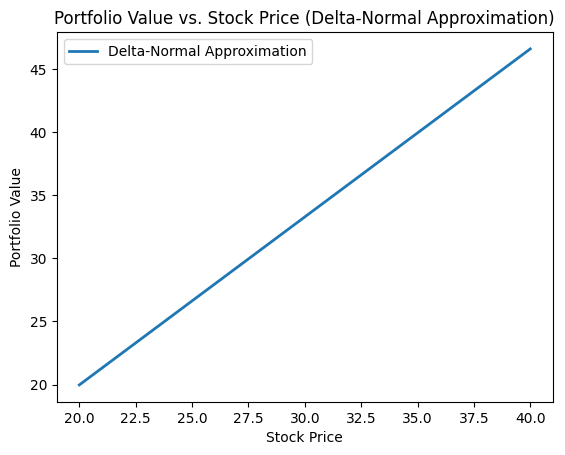

In [12]:
S_range = np.linspace(20, 40, 200)
portfolio_values = port_init + port_delta * (S_range - S) + port_theta * time_step

plt.plot(S_range, portfolio_values, label="Delta-Normal Approximation", lw=2)
plt.xlabel("Stock Price")
plt.ylabel("Portfolio Value")
plt.title("Portfolio Value vs. Stock Price (Delta-Normal Approximation)")
plt.legend()

Text(0.5, 1.0, 'Monte Carlo Simulation: Portfolio Value vs Stock Value')

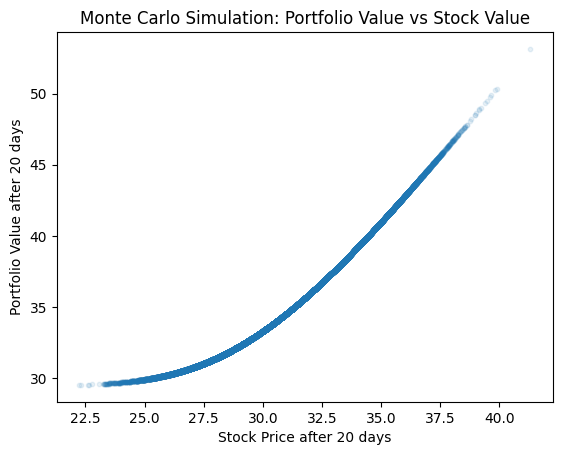

In [13]:
plt.scatter(S_sim, portfolio_sim, alpha=0.1, s=10)
plt.xlabel("Stock Price after 20 days")
plt.ylabel("Portfolio Value after 20 days")
plt.title("Monte Carlo Simulation: Portfolio Value vs Stock Value")